In [1]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
from tqdm import tqdm
import zarr
from wrf_diffusion.nimbuspp.parallel import parallelize
from wrf_diffusion.config import BASE_DIR
import os

In [2]:
era5_filename = f"{BASE_DIR}/preprocessed_data/ml_datasets/v6/ERA5.zarr"
# os.path.exists(era5_filename)
with zarr.open(era5_filename) as f:
    print(f['data'].attrs['varnames'][11])
    df_era5 = pd.DataFrame(
        data={'utc_timestamp':pd.to_datetime(f['utc_timestamp'][60000:61000], unit='s', utc=True),
              'q-700':f['data']['kauai'][60000:61000,10,0,2],
              'q-850':f['data']['kauai'][60000:61000,11,0,2]
              })

q-850


In [3]:
# Hanalei River nr Hanalei, Kauai, HI - USGS-16103000
site_id = '16103000'
minor_threshold = 5
major_threshold = 15.8
station_begin_date = '1990-10-01'
# https://waterdata.usgs.gov/monitoring-location/USGS-16103000/#dataTypeId=continuous-00065-0&startDT=2018-01-01&endDT=2018-12-31

In [4]:
start_timestamps = pd.date_range(start='2009-08-01', end='2009-12-31', freq=pd.tseries.offsets.MonthBegin(n=3))

In [5]:
start_timestamp = start_timestamps[0]

In [6]:
dfs = []
for start_timestamp in tqdm(start_timestamps):
    end_timestamp = start_timestamp + pd.tseries.offsets.MonthEnd(n=3)
    # url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites=16068000&agencyCd=USGS"
    url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites={site_id}&agencyCd=USGS"
    url += f"&startDT={start_timestamp.year}-{start_timestamp.month:02d}-{start_timestamp.day:02d}T00:00:00.000-10:00&endDT={end_timestamp.year}-{end_timestamp.month:02d}-{end_timestamp.day:02d}T23:59:59.999-10:00&parameterCd=00065&format=rdb"
    lines = requests.get(url).text.split('\n')

    timestamps, measurements = [], []
    for l in lines:
        if not l.startswith('USGS'): continue
        data_tuple = l.split('\t')
        [timestamps.append(data_tuple[2]), measurements.append(data_tuple[4])]
    df = pd.DataFrame(data={'utc_timestamp': pd.to_datetime(timestamps).tz_localize('HST').tz_convert('HST'), 'measurement': map(float, measurements)})
    dfs.append(df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.29s/it]


In [7]:
df_all = pd.concat(dfs).set_index('utc_timestamp').resample('1h').max()# Do not round to mean!

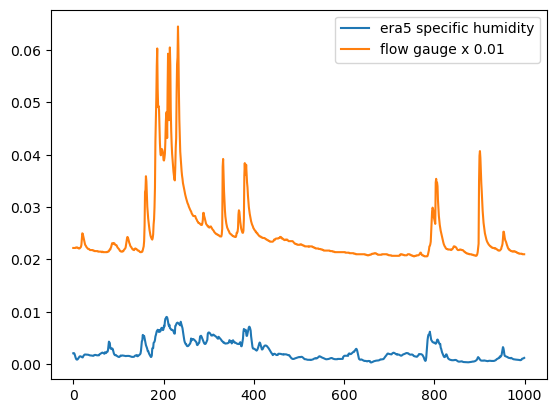

In [8]:
df_merged = pd.merge(df_all, df_era5, on='utc_timestamp')
fig, ax = plt.subplots(1)
ax.plot(df_merged['q-700'], label='era5 specific humidity')
# ax.plot(df_merged['q-850'], label='era5 specific humidity')
ax.plot(df_merged['measurement'] * 0.01, label='flow gauge x 0.01')
ax.legend()